Here, we examine parametric sensitivity of the structure model on a small simulated dataset

In [1]:
import jax

import jax.numpy as np
import jax.scipy as sp

from numpy.polynomial.hermite import hermgauss
import scipy as osp

from vb_lib import structure_model_lib, data_utils, cavi_lib
from vb_lib.preconditioner_lib import get_mfvb_cov_matmul
from bnpmodeling_runjingdev.sensitivity_lib import HyperparameterSensitivityLinearApproximation, get_jac_hvp_fun

import paragami

from copy import deepcopy

import time

import matplotlib.pyplot as plt
%matplotlib inline  

from bnpmodeling_runjingdev import cluster_quantities_lib, modeling_lib


/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
import numpy as onp
onp.random.seed(53453)

# Load data

In [3]:
# data = np.load('../simulated_data/simulated_structure_data_nobs20_nloci50_npop4.npz')
# g_obs = np.array(data['g_obs'])

In [4]:
data_dir = '../../../../fastStructure/hgdp_data/huang2011_plink_files/'
filenamebase = 'phased_HGDP+India+Africa_2810SNPs-regions1to36'
filename = data_dir + filenamebase + '.npz'
data = np.load(filename)

g_obs = np.array(data['g_obs'])
g_obs_raw = np.array(data['g_obs_raw'])

# just checking ... 
which_missing = (g_obs_raw == 3)
(g_obs.argmax(-1) == g_obs_raw)[~which_missing].all()
(g_obs[which_missing] == 0).all()

DeviceArray(True, dtype=bool)

In [5]:
n_obs = g_obs.shape[0]
n_loci = g_obs.shape[1]

# Get prior

In [6]:
prior_params_dict, prior_params_paragami = \
    structure_model_lib.get_default_prior_params()

print(prior_params_paragami)

prior_params_free = prior_params_paragami.flatten(prior_params_dict, free = True)

OrderedDict:
	[dp_prior_alpha] = NumericArrayPattern (1,) (lb=0.0, ub=inf)
	[allele_prior_alpha] = NumericArrayPattern (1,) (lb=0.0, ub=inf)
	[allele_prior_beta] = NumericArrayPattern (1,) (lb=0.0, ub=inf)


# Get VB params 

In [7]:
k_approx = 15

In [8]:
gh_deg = 8
gh_loc, gh_weights = hermgauss(8)

In [9]:
use_logitnormal_sticks = True

vb_params_dict, vb_params_paragami = \
    structure_model_lib.get_vb_params_paragami_object(n_obs, n_loci, k_approx,
                                    use_logitnormal_sticks = use_logitnormal_sticks)
    
print(vb_params_paragami)

OrderedDict:
	[pop_freq_beta_params] = NumericArrayPattern (2810, 15, 2) (lb=0.0, ub=inf)
	[ind_mix_stick_propn_mean] = NumericArrayPattern (1107, 14) (lb=-inf, ub=inf)
	[ind_mix_stick_propn_info] = NumericArrayPattern (1107, 14) (lb=0.0001, ub=inf)


## Initialize 

In [10]:
vb_params_dict = \
        structure_model_lib.set_init_vb_params(g_obs, k_approx, vb_params_dict,
                                                seed = 34221)

In [11]:
vb_params_dict.keys()

odict_keys(['pop_freq_beta_params', 'ind_mix_stick_propn_mean', 'ind_mix_stick_propn_info'])

In [12]:
def get_vb_expectations(vb_params_dict, use_logitnormal_sticks): 
    if use_logitnormal_sticks: 
        e_ind_admix = cluster_quantities_lib.get_e_cluster_probabilities(
                            vb_params_dict['ind_mix_stick_propn_mean'], 
                            vb_params_dict['ind_mix_stick_propn_info'],
                            gh_loc, gh_weights)

    else: 
        ind_mix_stick_beta_params = vb_params_dict['ind_mix_stick_beta_params']
        e_stick_lengths = \
                modeling_lib.get_e_beta(ind_mix_stick_beta_params)
        e_ind_admix = cluster_quantities_lib.get_mixture_weights_from_stick_break_propns(e_stick_lengths)

    e_pop_freq = modeling_lib.get_e_beta(vb_params_dict['pop_freq_beta_params'])
    
    return e_ind_admix, e_pop_freq

Text(0.5, 0, 'individual')

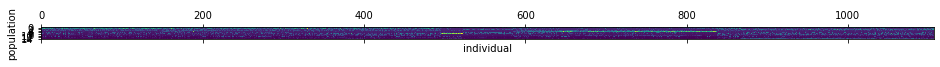

In [13]:
plt.matshow(get_vb_expectations(vb_params_dict, use_logitnormal_sticks)[0].transpose())
plt.ylabel('population')
plt.xlabel('individual')

# Optimize

In [14]:
from vb_lib.structure_optimization_lib import define_structure_objective
from bnpmodeling_runjingdev.optimization_lib import run_lbfgs

In [15]:
optim_objective, init_vb_free = \
    define_structure_objective(g_obs, vb_params_dict,
                        vb_params_paragami,
                        prior_params_dict,
                        gh_loc = gh_loc,
                        gh_weights = gh_weights)

Compiling objective ...
Iter 0: f = 31871746.55565094
Compiling grad ...
Compile time: 31.8895secs


In [16]:
optim_objective.set_log_every(1)

In [ ]:
out = run_lbfgs(optim_objective, init_vb_free)


Running L-BFGS-B ... 
Iter 0: f = 31871746.55565094
Iter 1: f = 31592084.21722268
Iter 2: f = 30493490.80264258
Iter 3: f = 26532793.58433259
Iter 4: f = 13464331.21635668
Iter 5: f = 11741588.76323786
Iter 6: f = 8678334.42004205
Iter 7: f = 7543829.83328556
Iter 8: f = 7191467.04831182
Iter 9: f = 6808420.19750233
Iter 10: f = 6547866.17920006
Iter 11: f = 6283530.48445798
Iter 12: f = 6136842.66675267
Iter 13: f = 6032174.72398183
Iter 14: f = 5941469.58994870
Iter 15: f = 5866453.18577227
Iter 16: f = 5720665.01832501
Iter 17: f = 2201194556282.83789062
Iter 18: f = 5525804.34442202
Iter 19: f = 548617853312.28411865
Iter 20: f = 5591549.24548985


In [15]:
vb_opt_dict, vb_out, optim_out, optim_objective = \
    optimize_structure(g_obs, vb_params_dict,
                        vb_params_paragami,
                        prior_params_dict,
                        gh_loc = gh_loc,
                        gh_weights = gh_weights)


Compiling objective ...
Iter 0: f = 31871746.55565094
Compiling grad ...
Compile time: 31.7353secs

Running L-BFGS-B ... 
Iter 1: f = 31871746.55565094
Iter 2: f = 31592084.21722268
Iter 3: f = 30493490.80264258
Iter 4: f = 26532793.58433259
Iter 5: f = 13464331.21635668
Iter 6: f = 11741588.76323786
Iter 7: f = 8678334.42004205
Iter 8: f = 7543829.83328556
Iter 9: f = 7191467.04831182
Iter 10: f = 6808420.19750233
Iter 11: f = 6547866.17920006
Iter 12: f = 6283530.48445798
Iter 13: f = 6136842.66675267
Iter 14: f = 6032174.72398183
Iter 15: f = 5941469.58994870
Iter 16: f = 5866453.18577227
Iter 17: f = 5720665.01832501
Iter 18: f = 2201194556282.83789062


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3319, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-15-4a42743d4e8d>", line 2, in <module>
    optimize_structure(g_obs, vb_params_dict,
  File "/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.8/site-packages/vb_lib/structure_optimization_lib.py", line 33, in optimize_structure
    optim_out = optimization_lib.run_lbfgs(kl_fun_free, init_vb_free, maxiter = maxiter)
  File "/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.8/site-packages/bnpmodeling_runjingdev/optimization_lib.py", line 99, in run_lbfgs
    out = optimize.minimize(optim_objective.f_np,
  File "/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.8/site-packages/scipy/optimize/_minimize.py", line 609, in minimize
    return _minimize_lbfgsb(fun, x0, 

KeyboardInterrupt: 

In [ ]:
structure_model_lib.get_kl(g_obs, vb_opt_dict, prior_params_dict,
                            gh_loc, gh_weights)

# Check out the fit

In [ ]:
# fitted
e_ind_admix = get_vb_expectations(vb_opt_dict, use_logitnormal_sticks)[0]
plt.matshow(e_ind_admix.T)